In [4]:
import os
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import SGD
import tensorflow
from scipy.interpolate import make_interp_spline
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
keras.__version__

'2.6.0'

In [6]:
tensorflow.__version__

'2.6.0'

In [7]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

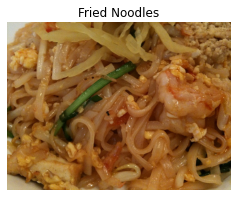

In [9]:
img = load_img('images/4012787089_d1cca54838.jpg')
plt.figure(figsize = (4,4))
plt.imshow(img)
plt.axis('off')
plt.title('Fried Noodles')
plt.show()

In [10]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

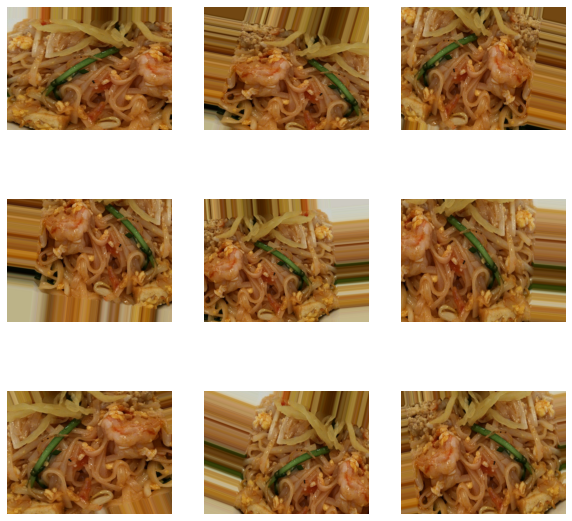

In [13]:
i = 0
fig = plt.figure(figsize = (10,10))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

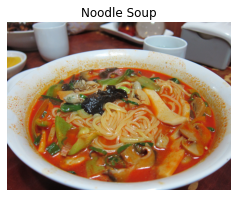

In [14]:
img = load_img('images/5153183161_eb845fb8d9_b.jpg')
plt.figure(figsize = (4,4))
plt.imshow(img)
plt.axis('off')
plt.title('Noodle Soup')
plt.show()

In [15]:
# default settings
img_width, img_height = 299, 299

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 20
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

In [16]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

315


In [17]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

36


In [18]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [19]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [20]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 315 images belonging to 2 classes.


In [21]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 36 images belonging to 2 classes.


In [22]:
# set up transfer learning on pre-trained ImageNet VGG19 model - remove fully connected layer and replace
# with softmax for classifying 2 classes
vgg19_model = VGG19(weights = 'imagenet', include_top = False)
x = vgg19_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = vgg19_model.input, output = predictions)

80150528/80134624 [==============================] - 11s 0us/step


TypeError: ('Keyword argument not understood:', 'input')

In [17]:
# freeze all layers of the pre-trained model
for layer in vgg19_model.layers:
    layer.trainable = False

In [18]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [19]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
251/251 [==============================] - 373s - loss: 0.9525 - acc: 0.5697 - val_loss: 0.9621 - val_acc: 0.5493
Epoch 2/20
251/251 [==============================] - 364s - loss: 0.5362 - acc: 0.7530 - val_loss: 0.4376 - val_acc: 0.8592
Epoch 3/20
251/251 [==============================] - 364s - loss: 0.4988 - acc: 0.7530 - val_loss: 0.5208 - val_acc: 0.7746
Epoch 4/20
251/251 [==============================] - 364s - loss: 0.4145 - acc: 0.8247 - val_loss: 0.7225 - val_acc: 0.6338
Epoch 5/20
251/251 [==============================] - 364s - loss: 0.4596 - acc: 0.7530 - val_loss: 0.4440 - val_acc: 0.8028
Epoch 6/20
251/251 [==============================] - 364s - loss: 0.3770 - acc: 0.8088 - val_loss: 0.4246 - val_acc: 0.8169
Epoch 7/20
251/251 [==============================] - 363s - loss: 0.4641 - acc: 0.7849 - val_loss: 0.7262 - val_acc: 0.6338
Epoch 8/20
251/251 [==============================] - 364s - loss: 0.5007 - acc: 0.7570 - val_loss: 0.5011 - val_acc: 0.7606


In [20]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.500604093075
Test Accuracy: 0.857142865658


In [21]:
# save transfer learning model for offline prediction purposes
model.save('noodles_vgg19_model_tl.h5')

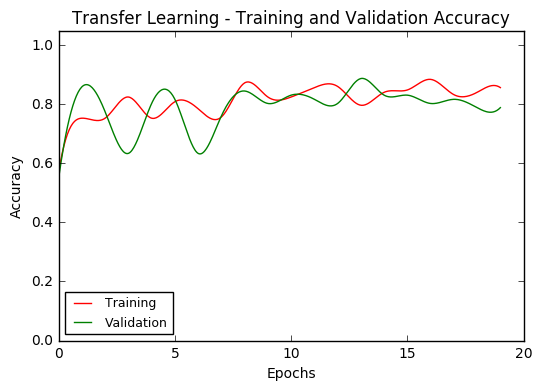

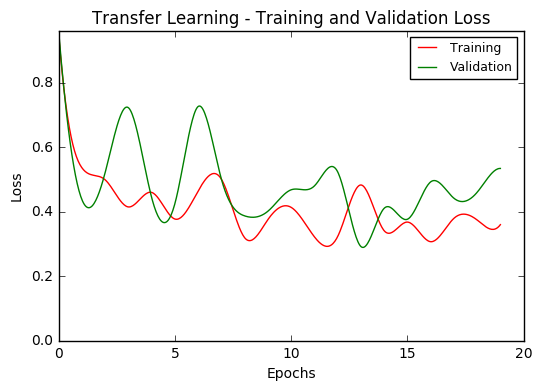

In [22]:
xfer_acc = transfer_learning_history.history['acc']
val_acc = transfer_learning_history.history['val_acc']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = make_interp_spline(x,y)(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = make_interp_spline(x1,y1)(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.05)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = make_interp_spline(x,y)(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = make_interp_spline(x1,y1)(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(y1))
plt.show()

In [23]:
validate_generator.total_batches_seen

266

In [24]:
predict_files = glob.glob("noodles_test/*.jpg")

In [25]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [26]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [27]:
final = pd.DataFrame()
final["id"] = image_id
final["Noodles"] = predictor
final.head(29)

,id,Noodles
0,noodles_fried_1362891196_7d75cf20f2_b.jpg,1
1,noodles_fried_14184195178_547c97c26f.jpg,1
2,noodles_fried_16396588549_e6c8e4d8f4_b.jpg,1
3,noodles_fried_17039137251_62c9fc6fa7_b.jpg,1
4,noodles_fried_20756744642_88b25bfe65_b.jpg,1
5,noodles_fried_3124561235_f2364895d8_b.jpg,0
6,noodles_fried_3375141488_8da8f7a1ae.jpg,1
7,noodles_fried_3675581924_7c531552ec_b.jpg,1
8,noodles_fried_3845786256_c7a572d603_b.jpg,1
9,noodles_fried_4042684214_8060899bfc_b.jpg,1


In [28]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [29]:
final["Noodles"] = final["Noodles"].apply(lambda x: classes[x])
final.head(29)

,id,Noodles
0,noodles_fried_1362891196_7d75cf20f2_b.jpg,noodles_fried
1,noodles_fried_14184195178_547c97c26f.jpg,noodles_fried
2,noodles_fried_16396588549_e6c8e4d8f4_b.jpg,noodles_fried
3,noodles_fried_17039137251_62c9fc6fa7_b.jpg,noodles_fried
4,noodles_fried_20756744642_88b25bfe65_b.jpg,noodles_fried
5,noodles_fried_3124561235_f2364895d8_b.jpg,noodle_soup
6,noodles_fried_3375141488_8da8f7a1ae.jpg,noodles_fried
7,noodles_fried_3675581924_7c531552ec_b.jpg,noodles_fried
8,noodles_fried_3845786256_c7a572d603_b.jpg,noodles_fried
9,noodles_fried_4042684214_8060899bfc_b.jpg,noodles_fried


In [30]:
final.to_csv("csv/noodles_with_pretrained_vgg19_model_tl_test.csv", index = False)

In [31]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 globalaveragepooling2d_1
23 dense_1
24 dense_2


In [32]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, None, None, 64 1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, None, None, 64 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, None, None, 64 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [33]:
# Step 1 - Set up fine tuning on pre-trained ImageNet VGG19 model - train all layers
for layer in model.layers:
    layer.trainable = True
    
# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
251/251 [==============================] - 902s - loss: 0.3075 - acc: 0.8765 - val_loss: 0.3388 - val_acc: 0.8732
Epoch 2/20
251/251 [==============================] - 896s - loss: 0.2723 - acc: 0.8845 - val_loss: 0.4422 - val_acc: 0.8451
Epoch 3/20
251/251 [==============================] - 902s - loss: 0.2785 - acc: 0.8765 - val_loss: 0.2700 - val_acc: 0.8873
Epoch 4/20
251/251 [==============================] - 900s - loss: 0.2618 - acc: 0.9084 - val_loss: 0.3584 - val_acc: 0.8451
Epoch 5/20
251/251 [==============================] - 902s - loss: 0.1843 - acc: 0.9363 - val_loss: 0.3627 - val_acc: 0.8310
Epoch 6/20
251/251 [==============================] - 915s - loss: 0.2200 - acc: 0.9084 - val_loss: 0.4140 - val_acc: 0.8169
Epoch 7/20
251/251 [==============================] - 902s - loss: 0.2086 - acc: 0.9283 - val_loss: 0.2321 - val_acc: 0.9014
Epoch 8/20
251/251 [==============================] - 902s - loss: 0.1944 - acc: 0.9203 - val_loss: 0.3920 - val_acc: 0.8169


In [34]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.582949399948
Test Accuracy: 0.78125


In [35]:
# save fine-tuning model for offline prediction purposes
model.save('noodles_vgg19_model_ft.h5')

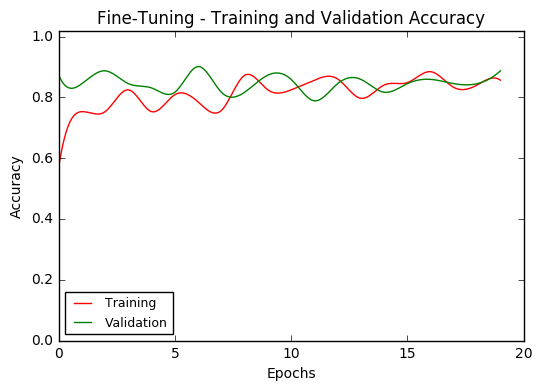

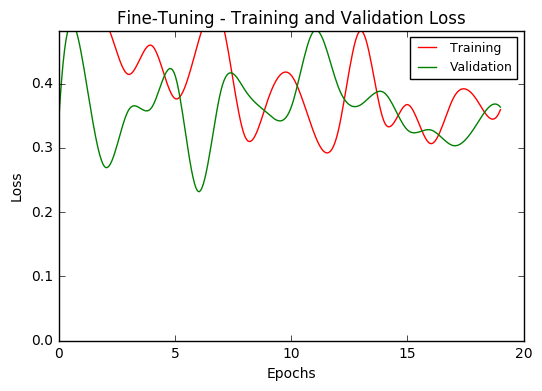

In [36]:
ft_acc = fine_tuning_history.history['acc']
val_acc = fine_tuning_history.history['val_acc']
ft_loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']
epochs = range(len(ft_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.02)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(y1))
plt.show()

In [37]:
validate_generator.total_batches_seen

537

In [38]:
# predict unseen images
predict_files = glob.glob("noodles_test/*.jpg")

In [39]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [40]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [41]:
final = pd.DataFrame()
final["id"] = image_id
final["Noodles"] = predictor 
final.head(29)

,id,Noodles
0,noodles_fried_1362891196_7d75cf20f2_b.jpg,1
1,noodles_fried_14184195178_547c97c26f.jpg,1
2,noodles_fried_16396588549_e6c8e4d8f4_b.jpg,1
3,noodles_fried_17039137251_62c9fc6fa7_b.jpg,1
4,noodles_fried_20756744642_88b25bfe65_b.jpg,1
5,noodles_fried_3124561235_f2364895d8_b.jpg,0
6,noodles_fried_3375141488_8da8f7a1ae.jpg,1
7,noodles_fried_3675581924_7c531552ec_b.jpg,1
8,noodles_fried_3845786256_c7a572d603_b.jpg,1
9,noodles_fried_4042684214_8060899bfc_b.jpg,1


In [42]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [43]:
final["Noodles"] = final["Noodles"].apply(lambda x: classes[x])
final.head(29)

,id,Noodles
0,noodles_fried_1362891196_7d75cf20f2_b.jpg,noodles_fried
1,noodles_fried_14184195178_547c97c26f.jpg,noodles_fried
2,noodles_fried_16396588549_e6c8e4d8f4_b.jpg,noodles_fried
3,noodles_fried_17039137251_62c9fc6fa7_b.jpg,noodles_fried
4,noodles_fried_20756744642_88b25bfe65_b.jpg,noodles_fried
5,noodles_fried_3124561235_f2364895d8_b.jpg,noodle_soup
6,noodles_fried_3375141488_8da8f7a1ae.jpg,noodles_fried
7,noodles_fried_3675581924_7c531552ec_b.jpg,noodles_fried
8,noodles_fried_3845786256_c7a572d603_b.jpg,noodles_fried
9,noodles_fried_4042684214_8060899bfc_b.jpg,noodles_fried


In [44]:
final.to_csv("csv/noodles_with_pretrained_vgg19_model_ft_test.csv", index = False)